# ISTAT Microdata Extractor example notebook
## 2. Pairing family members and joint probability distribution extraction

This notebok provides a usage example of the ISTAT Microdata Extractor tool for navigating and processing the [ISTAT microdata](https://www.istat.it/microdati/aspetti-della-vita-quotidiana/) from the survey **"Aspetti della Vita Quotidiana" (AVQ)**. It includes a Python class `ISTATMicrodataExtractor` with structured methods to explore, query, and analyze the AVQ dataset efficiently.

In this example we will extract the joint probability distribution of the mother-child ages in the regions Valle d'Aosta, Piemonte and Lombardia from the dataset.

To do so, we need to filter the dataset on the regions and pair the individuals of the same familiy to match mothers and children.

In [1]:
!pip install lxml

In [145]:
!conda install seaborn --yes

Channels:
 - huggingface
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/clearbox

  added / updated specs:
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    contourpy-1.3.2            |  py311h210dab8_0         243 KB  conda-forge
    fonttools-4.58.1           |  py311h4921393_0         2.7 MB  conda-forge
    matplotlib-base-3.10.3     |  py311h031da69_0         7.7 MB  conda-forge
    pillow-11.2.1              |  py311hb9ba9e9_0        40.7 MB  conda-forge
    seaborn-0.13.2             |       hd8ed1ab_3           7 KB  conda-forge
    seaborn-base-0.13.2        |     pyhd8ed1ab_3         223 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        51.5 MB

The following NEW packages will be INSTALLE

In [2]:
import polars as pl
from microdata_extractor import ISTATMicrodataExtractor

In [3]:
# Initialize the class and load the data
avq = ISTATMicrodataExtractor()
avq.load_data("../data/AVQ_2022_IT")

In [4]:
avq.df

PROFAM,PROIND,NCOMP,ANNO,RELPAR,ETAMi,SESSO,STCIVMi,STCPM,AMATR,ISTRMi,CONDMi,LAVPAS,POSIZMi,ATECOMi,TIPNU2,NUMNU2,RPNUC2,TIPFA2Mi,REGMf,RIPMf,COEFIN,REDPRMi,CITTMi,MOTAS,DADLEZOL,DADPC,DADTB,DADCELL,DADDIFF,DADDIF1,DADDIF2,DADDIF3,DADDIF3_BIS,DADDIF4,DADDIF5,DADDIF6,…,NCLIMAT,BIC,NBIC,MOTOR,NMOTOR,AMOTO,NMOTOM,AUTO,NAUTOM,BOX,NBOX,LIBFAM,TELCEL,NTELCELM,TELCIN,PC,VGIOC,NVIGIOC,EBOOK,NEBOOKM,FOTODIG,NFOTODIG,AINTERN,CIDSLWIFI,CISFPAL,CISFMOD,CIBASTR,MOTNOAI1,MOTNOAI3,MOTNOAI4,MOTNOAI5,MOTNOAI6,MOTNOAI8,MOTNOAI10,MOTNOAI9,SITE,RISEC
i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,i64,str,i64,str,i64,str,i64,str,str,str,i64,i64,str,str,i64,i64,str,i64,str,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64
1,1,1,2022,1,15,2,"""6""",null,null,"""10""","""3""","""2""","""04""",null,0,0,0,1,80,2,19501930,"""3""",1,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""2""",3,null,5,null,7,null,1,null,null,null,4,1,null,null,1,1,null,3,null,5,null,1,null,null,null,null,null,null,null,null,"""5""",null,null,null,4,3
2,1,4,2022,1,11,1,"""2""","""1""","""1997""","""07""","""1""",null,"""02""","""02""",1,1,2,2,80,2,19200992,"""1""",1,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""3""",4,"""1""",5,null,8,"""1""",2,"""2""","""2""","""2""",2,2,"""4""","""2""",2,2,"""2""",3,null,6,"""1""",2,"""1""",null,null,null,null,null,null,null,null,null,null,null,5,3
2,2,4,2022,2,11,2,"""2""","""1""","""1997""","""07""","""1""",null,"""02""","""02""",1,1,1,2,80,2,19200992,"""1""",1,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""3""",4,"""1""",5,null,8,"""1""",2,"""2""","""2""","""2""",2,2,"""4""","""2""",2,2,"""2""",3,null,6,"""1""",2,"""1""",null,null,null,null,null,null,null,null,null,null,null,5,3
2,3,4,2022,6,8,2,"""1""",null,null,"""07""","""3""","""2""","""04""",null,1,1,3,2,80,2,19200992,"""6""",1,null,null,null,null,null,null,null,null,null,null,null,null,null,…,"""3""",4,"""1""",5,null,8,"""1""",2,"""2""","""2""","""2""",2,2,"""4""","""2""",2,2,"""2""",3,null,6,"""1""",2,"""1""",null,null,null,null,null,null,null,null,null,null,null,5,3
2,4,4,2022,6,5,1,"""1""",null,null,"""09""","""3""",null,null,null,1,1,3,2,80,2,19200992,"""6""",1,null,"""1""",null,null,null,null,null,null,null,null,null,null,null,…,"""3""",4,"""1""",5,null,8,"""1""",2,"""2""","""2""","""2""",2,2,"""4""","""2""",2,2,"""2""",3,null,6,"""1""",2,"""1""",null,null,null,null,null,null,null,null,null,null,null,5,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
18432,4,4,2022,6,8,2,"""1""",null,null,"""07""","""2""","""1""",null,null,1,1,3,2,10,1,9974438,"""6""",1,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,4,"""2""",5,null,7,null,1,null,null,null,5,2,"""4""","""2""",2,2,"""2""",4,"""1""",6,"""1""",2,"""1""","""2""",null,null,null,null,null,null,null,null,null,null,2,2
18433,1,4,2022,1,11,1,"""3""",null,null,"""07""","""1""",null,"""01""","""03""",1,1,2,2,10,1,10553667,"""2""",1,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,4,"""2""",5,null,7,null,2,"""3""","""1""",null,3,2,"""4""","""2""",2,1,null,3,null,5,null,2,"""1""",null,null,null,null,null,null,null,null,null,null,null,4,2
18433,2,4,2022,3,12,2,"""3""",null,null,"""09""","""2""","""2""","""03""",null,1,1,1,2,10,1,10553667,"""6""",1,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,4,"""2""",5,null,7,null,2,"""3""","""1""",null,3,2,"""4""","""2""",2,1,null,3,null,5,null,2,"""1""",null,null,null,null,null,null,null,null,null,null,null,4,2


## Attributes categorization

The dataset is collected from a survey submitted to more than 18000 italian families and features **741 attributes** about over 42000 individuals (2022 survey).

The folder data in the [Github repository](https://github.com/Clearbox-AI/ISTAT-microdata-extractor) provides the data downloaded from the relative [ISTAT page](https://www.istat.it/microdati/aspetti-della-vita-quotidiana/) where it was added a file "AVQ_attributes_categories.csv" where each attribute is labeled with up to three categories to make the consultation of the dataset easier.

These attributes' categories are merged to the original "AVQ_Tracciato_2022.html" file into "AVQ_Tracciato_2022_with_categories.csv".

This file makes it possible to consult the attributes by categories.

The categories available can be viewed with:

In [5]:
avq.attribute_categories

['finance',
 'digital',
 'sport',
 None,
 'culture',
 'employment',
 'health_conditions',
 'energy',
 'identifiers',
 'food_drink',
 'other',
 'social_relations',
 'demographics',
 'trust',
 'social_commitment',
 'entertainment',
 'income',
 'traveling',
 'transportation',
 'house',
 'goods',
 'health_behaviour',
 'education',
 'healthcare',
 'opinion',
 'purchase_habits']

Once we have identified the categories we are interested in from the list above, it is possible to filter out the attributes based on the categories and consult their description to find the attributes we need.

In [6]:
# It is possible to pass up to three categories to the method get_attributes_by_categories().
_ = avq.get_attributes_by_categories("demographics", print_output=True)

29 attributes matching the search criteria
Results for categories demographics:

n°   Attribute	Description
-----------------------------------------------------
1    PROFAM:	progressivo famiglia
2    PROIND:	numero d'ordine del componente
3    NCOMP:	n� dei componenti la famiglia attuale
5    RELPAR:	relazione di parentela con la persona di riferimento
6    ETAMi:	Et� in anni compiuti
7    SESSO:	Sesso - scheda generale
8    STCIVMi:	Stato civile
9    STCPM:	Stato civile precedente il matrimonio
10   AMATR:	Anno del matrimonio
16   TIPNU2:	Tipo nucleo 2
17   NUMNU2:	Numero progressivo del nucleo nell'ambito della famiglia 2
18   RPNUC2:	Relazione di parentela nell'ambito del nucleo 2
19   TIPFA2Mi:	Tipologia familiare 2
20   REGMf:	Regione di residenza dell'intervistato
21   RIPMf:	Ripartizione geografica di residenza dell'intervistato
24   CITTMi:	Cittadinanza
31   DADDIF1:	Difficolt� incontrate nel seguire le lezioni online con gli insegnanti: le attrezzature informatiche in famigli

We are interested in the correlation between the age of the mother and the child.

So the attributes we need are:
- ETAMi: age
- SESSO: gender 
- RELPAR: relation between family members
- REGMf: region of residence

First we need to check out the categorical atributes' encoding.

In [7]:
_ = avq.get_attribute_metadata("ETAMi", print_output=True)
print("\n")
_ = avq.get_attribute_metadata("SESSO", print_output=True)
print("\n")
_ = avq.get_attribute_metadata("RELPAR", print_output=True)
print("\n")
_ = avq.get_attribute_metadata("REGMf", print_output=True)

Attribute:
   ETAMi
Description:
   Et� in anni compiuti
Encod.	Label
1	da 0 a 2 anni
2	da 3 a 5 anni
3	da 6 a 10 anni
4	da 11 a 13 anni
5	da 14 a 15 anni
6	da 16 a 17 anni
7	da 18 a 19 anni
8	da 20 a 24 anni
9	da 25 a 34 anni
10	da 35 a 44 anni
11	da 45 a 54 anni
12	da 55 a 59 anni
13	da 60 a 64 anni
14	da 65 a 74 anni
15	75 anni e piu'


Attribute:
   SESSO
Description:
   Sesso - scheda generale
Encod.	Label
1	maschio
2	femmina


Attribute:
   RELPAR
Description:
   relazione di parentela con la persona di riferimento
Encod.	Label
1	persona di riferimento PR
2	coniuge di PR
3	convivente (coniugalmente) di PR
4	genitore (coniuge del genitore, convivente del genitore) di PR
5	genitore (coniuge del genitore, convivente del genitore) del coniuge o convivente di PR
6	figlio di PR nato dall'ultimo matrimonio o convivenza
7	figlio di PR o del coniuge nato da precedente matrimonio o convivenza
8	coniuge del figlio di PR (o del coniuge o convivente di PR)
9	convivente del figlio di PR (o del

Let's define the filtering rules to:
- Extract the individuals living in Valle d'Aosta, Piemonte and Lombardia.
- Pair mohters and children within families, based on the RELPAR attribute.

In [8]:
regioni = ["Valle d\'Aosta","Piemonte","Lombardia"]
filter_df_rules = [("REGMf", "==", regioni)]

# In the mother-child rule, ind1 is the child and ind2 is the mother.
mother_child_rules = [
    {"name": "RELPAR_6",
    "ind1": [("RELPAR", "==", 6)],                      # Child
    "ind2": [("RELPAR", "==", 1), ("SESSO", "==", 2)]}, # Mother
    {"name": "RELPAR_7_1",
    "ind1": [("RELPAR", "==", 7)],                      # Child
    "ind2": [("RELPAR", "==", 1), ("SESSO", "==", 2)]}, # Mother
    {"name": "RELPAR_7_2",
    "ind1": [("RELPAR", "==", 7)],                      # Child
    "ind2": [("RELPAR", "==", 2), ("SESSO", "==", 2)]}, # Mother
    {"name": "RELPAR_4_1",
    "ind1": [("RELPAR", "==", 1)],                      # Child
    "ind2": [("RELPAR", "==", 4), ("SESSO", "==", 2)]}, # Mother
    {"name": "RELPAR_5_2",
    "ind1": [("RELPAR", "==", 2)],                      # Child
    "ind2": [("RELPAR", "==", 5), ("SESSO", "==", 2)]}, # Mother
    {"name": "RELPAR_5_2",
    "ind1": [("RELPAR", "==", 3)],                      # Child
    "ind2": [("RELPAR", "==", 5), ("SESSO", "==", 2)]}, # Mother
    {"name": "RELPAR_5_2",
    "ind1": [("RELPAR", "==", 3)],                      # Child
    "ind2": [("RELPAR", "==", 5), ("SESSO", "==", 2)]}, # Mother
    {"name": "Fallback_RELPAR_6_2",
    "ind1": [("RELPAR", "==", 6)],                      # Child
    "ind2": [("RELPAR", "==", 2), ("SESSO", "==", 2)]}, # Mother
]

Now let's extract the dataframe with the individuals paired according to the rules defined.

In [9]:
attrs_pair = ["ETAMi"] # These are the attributes that will be returned.
mother_child_pairs_df = avq.pair_family_members(
        mother_child_rules, 
        attrs=attrs_pair, 
        filter_df_rules=filter_df_rules
    )

# Discard rows where the mother's age (ETAMi_ind2) is lower or equal to the child's age (ETAMi_ind1)
mother_child_pairs_df = mother_child_pairs_df.filter(
    ~((pl.col("ETAMi_ind2") <= pl.col("ETAMi_ind1")) &
        (pl.col("ETAMi_ind2") < 15) # ETAMi=15 -> "older than 75 years old" (there can be mother and child both older than 75))
    )
)

In [30]:
mother_child_pairs_df["PROFAM"].unique().count()

1256

In [33]:
mother_child_pairs_df["ETAMi_ind2"].value_counts()

ETAMi_ind2,count
i64,u32
12,268
14,119
9,139
10,515
13,145
8,13
15,115
11,680


Finally we can extract the joint probability distribution of mother-child age

In [85]:
# joint is the dataframe with the joint distribution.
joint, _ = avq.joint_distribution(
            attrs=["ETAMi_ind1", "ETAMi_ind2"],
            df=mother_child_pairs_df,
            normalise=True,
        )

# Rename the columns for clarity
joint = joint.rename(
    {
        "ETAMi_ind1": "child_age",
        "ETAMi_ind2": "mother_age"
    }
)
print(joint)

shape: (49, 4)
┌───────────┬────────────┬───────┬──────────┐
│ child_age ┆ mother_age ┆ count ┆ prob     │
│ ---       ┆ ---        ┆ ---   ┆ ---      │
│ i64       ┆ i64        ┆ u32   ┆ f64      │
╞═══════════╪════════════╪═══════╪══════════╡
│ 8         ┆ 11         ┆ 178   ┆ 0.089268 │
│ 3         ┆ 10         ┆ 174   ┆ 0.087262 │
│ 4         ┆ 11         ┆ 115   ┆ 0.057673 │
│ 9         ┆ 12         ┆ 108   ┆ 0.054162 │
│ 8         ┆ 12         ┆ 97    ┆ 0.048646 │
│ …         ┆ …          ┆ …     ┆ …        │
│ 9         ┆ 10         ┆ 2     ┆ 0.001003 │
│ 7         ┆ 9          ┆ 1     ┆ 0.000502 │
│ 4         ┆ 8          ┆ 1     ┆ 0.000502 │
│ 3         ┆ 8          ┆ 1     ┆ 0.000502 │
│ 5         ┆ 9          ┆ 1     ┆ 0.000502 │
└───────────┴────────────┴───────┴──────────┘


In [86]:
joint_prob_heatmap = (
    joint
    .pivot(
        values="prob",
        index="child_age", # Rows
        on="mother_age",        # Columns
        aggregate_function="first"  # assuming each pair is unique
    )
    .fill_null(0) # Fill NaN with 0
    .with_columns(pl.col("child_age").cast(pl.Int32))
    .sort("child_age", descending=True)  # Sort child_age descending (top to bottom)
)


# Sort columns by mother_age ascending (left to right)
mother_age_cols = sorted(
    [int(col) for col in joint_prob_heatmap.columns if col != "child_age"]
)
mother_age_cols_str = [str(col) for col in mother_age_cols]

joint_prob_heatmap = joint_prob_heatmap.select(["child_age"] + mother_age_cols_str)
joint_prob_heatmap

child_age,8,9,10,11,12,13,14,15
i32,f64,f64,f64,f64,f64,f64,f64,f64
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001505
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009529
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012036
11,0.0,0.0,0.0,0.0,0.0,0.0,0.019057,0.028084
10,0.0,0.0,0.0,0.0,0.005015,0.014544,0.027081,0.004514
…,…,…,…,…,…,…,…,…
5,0.0,0.000502,0.019559,0.03661,0.005517,0.0,0.0,0.0
4,0.000502,0.003511,0.043631,0.057673,0.003009,0.0,0.0,0.0
3,0.000502,0.017553,0.087262,0.037111,0.0,0.0,0.0,0.0


In [87]:
type(joint_prob_heatmap)

polars.dataframe.frame.DataFrame

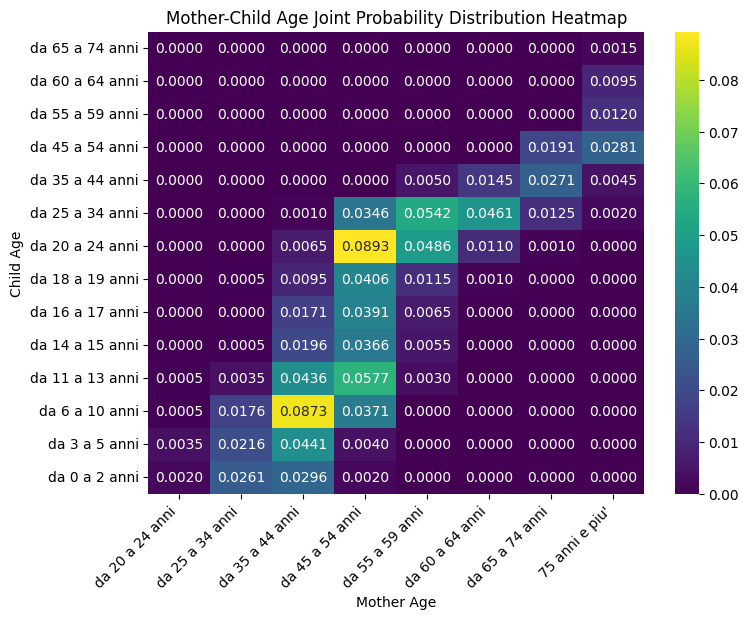

In [ ]:
# Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    joint_prob_heatmap[:,1:],
    cmap="viridis",
    annot=True,
    fmt=".4f"
)

# Set x and y labels
age_labels = avq.get_attribute_metadata("ETAMi", print_output=False)
xticks = joint_prob_heatmap.columns[1:]
yticks = joint_prob_heatmap.select(pl.col("child_age")).to_series().unique().sort(descending=True)
ax.set_xticks([el+0.5 for el in range(len(xticks))])
ax.set_xticklabels([age_labels.get(int(val)) for val in xticks], rotation=45, ha='right')

ax.set_yticks([el+0.5 for el in range(len(yticks))])
ax.set_yticklabels([age_labels.get(val) for val in yticks], rotation=0, ha='right')

plt.title("Mother-Child Age Joint Probability Distribution Heatmap")
plt.xlabel("Mother Age")
plt.ylabel("Child Age")
plt.show()

In [75]:
mother_child_pairs_df.sort(by="PROFAM", descending=False).head(20)

rule,PROFAM,PROIND_1,PROIND_2,ETAMi_ind1,ETAMi_ind2
str,i64,i64,i64,i64,i64
"""RELPAR_6""",278,2,1,3,10
"""RELPAR_6""",278,3,1,7,10
"""Fallback_RELPAR_6_2""",282,3,2,11,15
"""Fallback_RELPAR_6_2""",283,4,2,8,11
"""Fallback_RELPAR_6_2""",283,5,2,4,11
…,…,…,…,…,…
"""Fallback_RELPAR_6_2""",399,3,2,8,12
"""Fallback_RELPAR_6_2""",403,3,4,1,9
"""Fallback_RELPAR_6_2""",403,2,4,3,9


In [78]:
num_fam = mother_child_pairs_df["PROFAM"].shape[0]
num_mothers = mother_child_pairs_df["ETAMi_ind2"].value_counts()

In [79]:
for i, row in num_mothers.iter_rows():
    portion_mothers[i-1]= row/ num_fam

In [88]:
portion_mothers

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.006519558676028084,
 0.06970912738214644,
 0.25827482447342026,
 0.3410230692076229,
 0.13440320962888666,
 0.07271815446339017,
 0.059679037111334,
 0.057673019057171516]

In [64]:
num_mothers[0]

ETAMi_ind2,count
i64,u32
15,115


In [70]:
num_mothers["count"].sum()

1994

In [117]:
heatmap_2 = joint_prob_heatmap.clone()

In [118]:
heatmap_2

child_age,8,9,10,11,12,13,14,15
i32,f64,f64,f64,f64,f64,f64,f64,f64
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001505
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009529
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012036
11,0.0,0.0,0.0,0.0,0.0,0.0,0.019057,0.028084
10,0.0,0.0,0.0,0.0,0.005015,0.014544,0.027081,0.004514
…,…,…,…,…,…,…,…,…
5,0.0,0.000502,0.019559,0.03661,0.005517,0.0,0.0,0.0
4,0.000502,0.003511,0.043631,0.057673,0.003009,0.0,0.0,0.0
3,0.000502,0.017553,0.087262,0.037111,0.0,0.0,0.0,0.0


In [119]:
portion_mothers

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.006519558676028084,
 0.06970912738214644,
 0.25827482447342026,
 0.3410230692076229,
 0.13440320962888666,
 0.07271815446339017,
 0.059679037111334,
 0.057673019057171516]

In [120]:
heatmap_2.columns

['child_age', '8', '9', '10', '11', '12', '13', '14', '15']

In [104]:
heatmap_2[:,"8"]

8
f64
0.0
0.0
0.0
0.0
0.0
…
0.0
0.000502
0.000502


In [140]:
for i in range(len(portion_mothers)):
    if portion_mothers[i] >0:
        polar_index=str(i+1)
        # print(polar_index)
        heatmap_2 = heatmap_2.with_columns(
            pl.col(polar_index) /portion_mothers[i]
        )
        print(heatmap_2[:,polar_index].sum())

1.0
1.0
0.9999999999999999
0.9999999999999998
0.9999999999999998
1.0
1.0
1.0


In [141]:
 heatmap_2

child_age,8,9,10,11,12,13,14,15
i32,f64,f64,f64,f64,f64,f64,f64,f64
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026087
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165217
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208696
11,0.0,0.0,0.0,0.0,0.0,0.0,0.319328,0.486957
10,0.0,0.0,0.0,0.0,0.037313,0.2,0.453782,0.078261
…,…,…,…,…,…,…,…,…
5,0.0,0.007194,0.075728,0.107353,0.041045,0.0,0.0,0.0
4,0.076923,0.05036,0.168932,0.169118,0.022388,0.0,0.0,0.0
3,0.076923,0.251799,0.337864,0.108824,0.0,0.0,0.0,0.0


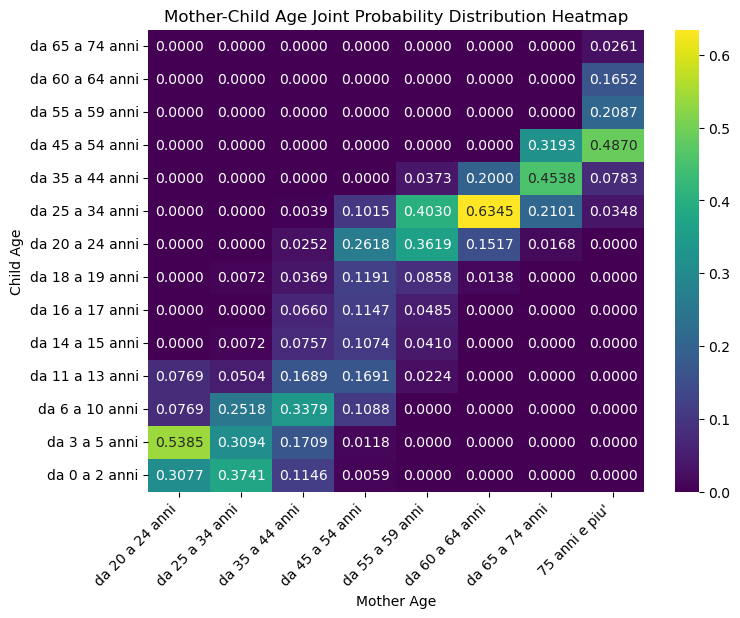

In [146]:
# Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    heatmap_2[:,1:],
    cmap="viridis",
    annot=True,
    fmt=".4f"
)

# Set x and y labels
age_labels = avq.get_attribute_metadata("ETAMi", print_output=False)
xticks = heatmap_2.columns[1:]
yticks = heatmap_2.select(pl.col("child_age")).to_series().unique().sort(descending=True)
ax.set_xticks([el+0.5 for el in range(len(xticks))])
ax.set_xticklabels([age_labels.get(int(val)) for val in xticks], rotation=45, ha='right')

ax.set_yticks([el+0.5 for el in range(len(yticks))])
ax.set_yticklabels([age_labels.get(val) for val in yticks], rotation=0, ha='right')

plt.title("Mother-Child Age Joint Probability Distribution Heatmap")
plt.xlabel("Mother Age")
plt.ylabel("Child Age")
plt.show()

In [148]:
import numpy as np

In [154]:
r_mother = np.random.rand()
print(r_mother)

0.24287022877903253 0.9222888000662942


In [152]:
portion_mothers

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.006519558676028084,
 0.06970912738214644,
 0.25827482447342026,
 0.3410230692076229,
 0.13440320962888666,
 0.07271815446339017,
 0.059679037111334,
 0.057673019057171516]

In [170]:
cumulative_mother = 0
for i in range(len(portion_mothers)):
    cumulative_mother += portion_mothers[i]
    if r_mother <= cumulative_mother:
        break
print(i+1)
polar_index = str(i+1)
c = list(heatmap_2[:,polar_index])
c.reverse()
print(c)

10
[0.1145631067961165, 0.170873786407767, 0.33786407766990295, 0.16893203883495148, 0.07572815533980583, 0.06601941747572815, 0.036893203883495145, 0.02524271844660194, 0.003883495145631068, 0.0, 0.0, 0.0, 0.0, 0.0]


In [219]:
c = list(heatmap_2[:,"8"])
c.reverse()
print(c)


[0.3076923076923077, 0.5384615384615384, 0.07692307692307693, 0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [220]:
from polars.exceptions import ColumnNotFoundError

for i in range(0,15):
    polar_index = str(i+1)
    try:
        c = list(heatmap_2[:,polar_index])
        c.reverse()
        print(polar_index, c)
    except ColumnNotFoundError:
        print([])

[]
[]
[]
[]
[]
[]
[]
8 [0.3076923076923077, 0.5384615384615384, 0.07692307692307693, 0.07692307692307693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
9 [0.37410071942446044, 0.30935251798561153, 0.2517985611510792, 0.05035971223021583, 0.007194244604316547, 0.0, 0.007194244604316547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10 [0.1145631067961165, 0.170873786407767, 0.33786407766990295, 0.16893203883495148, 0.07572815533980583, 0.06601941747572815, 0.036893203883495145, 0.02524271844660194, 0.003883495145631068, 0.0, 0.0, 0.0, 0.0, 0.0]
11 [0.0058823529411764705, 0.011764705882352941, 0.1088235294117647, 0.1691176470588235, 0.10735294117647058, 0.11470588235294117, 0.11911764705882354, 0.2617647058823529, 0.10147058823529412, 0.0, 0.0, 0.0, 0.0, 0.0]
12 [0.0, 0.0, 0.0, 0.02238805970149254, 0.041044776119402986, 0.048507462686567165, 0.08582089552238806, 0.3619402985074627, 0.4029850746268656, 0.03731343283582089, 0.0, 0.0, 0.0, 0.0]
13 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01379310344827586

In [182]:
hits = [0] *15
for k in range(10000):
    r_child = np.random.rand()
    # print(r_child)
    cumulative_child = 0
    for j in range(len(c)):
        cumulative_child += c[j]
        if r_child <= cumulative_child:
            break
    hits[j] +=1
print(hits)

[1163, 1715, 3345, 1753, 712, 640, 372, 251, 49, 0, 0, 0, 0, 0, 0]


ValueError: Incorrect use of keyword argument 'rotation'. Keyword arguments other than 'minor' modify the text labels and can only be used if 'labels' are passed as well.

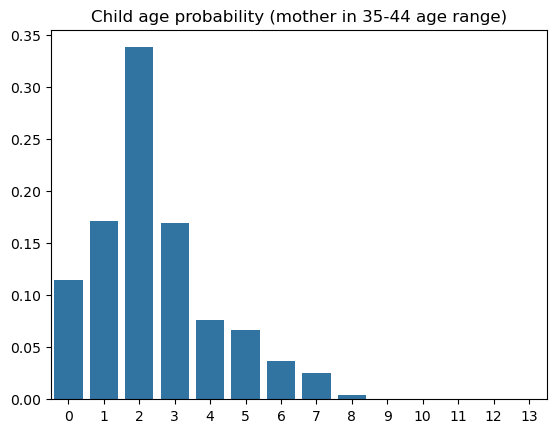

In [195]:
fig = sns.barplot(data=c)
fig.set_title("Child age probability (mother in 35-44 age range)")
fig.set_xticks(list(age_labels.values())[0:14], rotation=45, ha='right')

In [180]:
cumulative_child = 0
for j in range(len(c)):
    cumulative_child += c[j]
    if r_child <= cumulative_child:
        break
print(j+1)

4
